# Variational Autoencoder: LeNet-5 CNN with PyTorch and MNIST

[Reference](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L17/1_VAE_mnist_sigmoid_mse.ipynb) and [Second reference](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L17/helper_train.py)

In [ ]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [5]:
# Hyper-parameters-
num_epochs = 50
batch_size = 32
learning_rate = 0.001

### MNIST data pre-processing:

#### Compute mean and standard deviation for different datasets

```
import argparse
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms

dataset_names = ('cifar10','cifar100','mnist')

parser = argparse.ArgumentParser(description='PyTorchLab')
parser.add_argument('-d', '--dataset', metavar='DATA', default='cifar10', choices=dataset_names,
                    help='dataset to be used: ' + ' | '.join(dataset_names) + ' (default: cifar10)')

args = parser.parse_args()

data_dir = os.path.join('.', args.dataset)

print(args.dataset)

if args.dataset == "cifar10":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(train_set.train_data.shape)
    print(train_set.train_data.mean(axis=(0,1,2))/255)
    print(train_set.train_data.std(axis=(0,1,2))/255)

elif args.dataset == "cifar100":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.CIFAR100(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(train_set.train_data.shape)
    print(np.mean(train_set.train_data, axis=(0,1,2))/255)
    print(np.std(train_set.train_data, axis=(0,1,2))/255)

elif args.dataset == "mnist":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(list(train_set.train_data.size()))
    print(train_set.train_data.float().mean()/255)
    print(train_set.train_data.float().std()/255)
```

[Reference](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/11)

In [6]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [7]:
path_to_data = "C:\\Users\\arjun\Downloads\\"

In [8]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        # root = './data', train = True,
        root = path_to_data + "data", train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        # root = './data', train = False,
        root = path_to_data + "data", train = False,
        transform = transforms_apply
        )

In [9]:
print(f"training dataset length/shape: {list(train_dataset.data.size())}")

training dataset length/shape: [60000, 28, 28]


In [10]:
print(f"mean = {train_dataset.data.float().mean() / 255:.4f}")

mean = 0.1307


In [11]:
print(f"std dev = {train_dataset.data.float().std() / 255:.4f}")

std dev = 0.3081


#### NOTE:

Since MNIST has only one channel, therefore, the mean and standard deviation is computed for one channel!

In [12]:
# Sanity check-
train_dataset.data.min(), train_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [13]:
test_dataset.data.min(), test_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

#### Scale pixel values in the range 0 to 1

To manually convert the pixel values in the range 0 to 1.

In [14]:
train = train_dataset.data.float() / 255.0
test = test_dataset.data.float() / 255.0

In [15]:
type(train), type(test)

(torch.Tensor, torch.Tensor)

In [16]:
train.shape, test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [17]:
# Reshape to include gray-scale channel-
train = train.reshape(60000, 1, 28, 28)
test = test.reshape(10000, 1, 28, 28)

In [18]:
train.shape, test.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [19]:
# Sanity check- min and max pixel values are in the range 0 to 1-
train.data.min(), train.data.max()

(tensor(0.), tensor(1.))

In [20]:
test.data.min(), test.data.max()

(tensor(0.), tensor(1.))

In [21]:
del train_dataset, test_dataset

In [22]:
print(f"batch size to be used = {batch_size}")

batch size to be used = 32


In [23]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
        dataset = train, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test, batch_size = batch_size,
        shuffle = False
        )

In [24]:
print(f"Sizes of train_dataset: {len(train)} and test_dataet: {len(test)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 1875 and test_loader: 313


In [25]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 1875 & len(test_loader) = 313


In [26]:
# Sanity check-
len(train) / batch_size, len(test) / batch_size

(1875.0, 312.5)

In [27]:
# Get some random batch of training images & labels-
# images, labels = next(iter(train_loader))
images = next(iter(train_loader))

# You get 64 images due to the specified batch size-
# print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")
print(f"images.shape: {images.shape}")

images.shape: torch.Size([32, 1, 28, 28])


In [28]:
images.min(), images.max()

(tensor(0.), tensor(1.))

In [29]:
# De-normalize the batch of images-
images *= 255.0

In [30]:
images.min(), images.max()

(tensor(0.), tensor(255.))

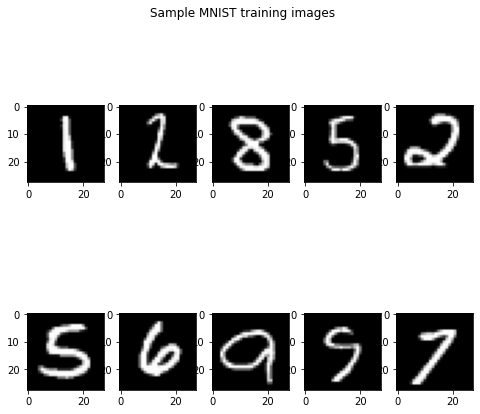

In [31]:
# Visualize 10 images from training set-
plt.figure(figsize = (8, 7))
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

### Define Variational Autoencoder architecture using _convolutional_ layers

In [32]:
class LeNet_Encoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet_Encoder, self).__init__()
        
        self.latent_space = latent_space
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 6,
            kernel_size = 3, stride = 2,
            padding = 1, bias = True
        )
        self.conv2 = nn.Conv2d(
            in_channels = 6, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.conv3 = nn.Conv2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.conv4 = nn.Conv2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.dense = nn.Linear(
            in_features = 64, out_features = 10,
            bias = True
        )
        '''
        self.dense2 = nn.Linear(
            in_features = 30, out_features = 10,
            bias = True
        )
        '''
        self.encoder_output = nn.Linear(
            in_features = 10, out_features = self.latent_space,
            bias = True
        )
        
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        # print(f"before flatten, x.shape: {x.shape}")
        x = torch.flatten(x, start_dim = 1)
        x = F.leaky_relu(self.dense(x))
        # x = F.leaky_relu(self.dense2(x))
        x = F.leaky_relu(self.encoder_output(x))
        return x
        
        
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv1(x)
        print(f"conv1 output shape: {x.shape}")
        x = self.conv2(x)
        print(f"conv2 output shape: {x.shape}")
        x = self.conv3(x)
        print(f"conv3 output shape: {x.shape}")
        x = self.conv4(x)
        print(f"conv4 output shape: {x.shape}")
        x = torch.flatten(x, start_dim = 1)
        print(f"flattened shape: {x.shape}")
        x = self.dense(x)
        print(f"dense output shape: {x.shape}")
        # x = self.dense2(x)
        # print(f"dense2 output shape: {x.shape}")
        x = self.encoder_output(x)
        print(f"encoder output shape: {x.shape}")
        del x
        return None
        

In [41]:
class LeNet_Decoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet_Decoder, self).__init__()
        
        self.latent_space = latent_space
        self.dense_layer1 = nn.Linear(
            in_features = self.latent_space, out_features = 10,
            bias = True
        )
        
        self.dense_layer2 = nn.Linear(
            in_features = 10, out_features = 64,
            bias = True
        )
        '''
        self.dense_layer3 = nn.Linear(
            in_features = 30, out_features = 64,
            bias = True
        )
        '''
        self.conv_tran_layer1 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.conv_tran_layer2 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.conv_tran_layer3 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 6,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.op_conv_tran_layer = nn.ConvTranspose2d(
            in_channels = 6, out_channels = 1,
            kernel_size = 2, stride = 2,
            padding = 0
        )
        
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.dense_layer1(x))
        x = F.leaky_relu(self.dense_layer2(x))
        # x = F.leaky_relu(self.dense_layer3(x))
        x = x.view(-1, 16, 2, 2)
        x = F.leaky_relu(self.conv_tran_layer1(x))
        x = F.leaky_relu(self.conv_tran_layer2(x))
        x = F.leaky_relu(self.conv_tran_layer3(x))
        x = self.op_conv_tran_layer(x)
        return x
 

    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.dense_layer1(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.dense_layer2(x)
        print(f"dense2 output shape: {x.shape}")
        # x = self.dense_layer3(x)
        # print(f"dense3 output shape: {x.shape}")
        x = x.view(-1, 16, 2, 2)
        print(f"reshaped output shape: {x.shape}")
        x = self.conv_tran_layer1(x)
        print(f"conv transpose1 output shape: {x.shape}")
        x = self.conv_tran_layer2(x)
        print(f"conv transpose2 output shape: {x.shape}")
        x = self.conv_tran_layer3(x)
        print(f"conv transpose3 output shape: {x.shape}")
        x = self.op_conv_tran_layer(x)
        print(f"decoder output shape: {x.shape}")
        del x
        return None


#### Sanity check

In [34]:
encoder = LeNet_Encoder(latent_space = 3)

In [35]:
encoded_images = encoder(images)

In [42]:
decoder = LeNet_Decoder(latent_space = 3)

In [43]:
decoded_images = decoder(encoded_images)

In [44]:
decoded_images.shape, images.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32, 1, 28, 28]))

In [39]:
encoder.shape_computation(images)

Input shape: torch.Size([32, 1, 28, 28])
conv1 output shape: torch.Size([32, 6, 14, 14])
conv2 output shape: torch.Size([32, 16, 10, 10])
conv3 output shape: torch.Size([32, 16, 6, 6])
conv4 output shape: torch.Size([32, 16, 2, 2])
flattened shape: torch.Size([32, 64])
dense output shape: torch.Size([32, 10])
encoder output shape: torch.Size([32, 3])


In [45]:
decoder.shape_computation(encoded_images)

Input shape: torch.Size([32, 3])
dense1 output shape: torch.Size([32, 10])
dense2 output shape: torch.Size([32, 64])
reshaped output shape: torch.Size([32, 16, 2, 2])
conv transpose1 output shape: torch.Size([32, 16, 6, 6])
conv transpose2 output shape: torch.Size([32, 16, 10, 10])
conv transpose3 output shape: torch.Size([32, 6, 14, 14])
decoder output shape: torch.Size([32, 1, 28, 28])


In [46]:
del encoded_images, decoded_images, encoder, decoder

In [47]:
class VAE_Conv(nn.Module):
    def __init__(self, latent_space = 5):
        super(VAE_Conv, self).__init__()
        
        self.latent_space = latent_space
        
        # Encoder-
        self.encoder = LeNet_Encoder(latent_space = self.latent_space).to(device)
        
        # Two additional layers 'mu' & 'log_var' to convert the bottleneck into the μ and σ vectors-
        self.mu = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        self.log_var = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        
        # Decoder-
        self.decoder = LeNet_Decoder(latent_space = self.latent_space).to(device)
        
        
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' samples from a normal standard distribution to add
        # stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        z = mu + (std * eps)
        
        return z
    
    
    def forward(self, x):
        # Encode input data-
        x = self.encoder(x)
        # NOTE: The line of code above does NOT give us the latent vector!
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, log_var)
        # latent vector 'z' is obtained through reparameterization trick using mu and log_var
        
        # Decode latent vector-
        recon_data = torch.sigmoid(self.decoder(z))
        # recon_data = torch.tanh(self.decoder(z))
        
        return recon_data, mu, log_var
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.encoder(x)
        print(f"Encoder output shape: {x.shape}")
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        x = self.decoder(z)
        print(f"Decoder output shape: {x.shape}")
        del x, mu, log_var, z
        return None
    
    

In [48]:
# Initialize a VAE objetc-
model = VAE_Conv(latent_space = 3).to(device)

In [49]:
print(model)

VAE_Conv(
  (encoder): LeNet_Encoder(
    (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (dense): Linear(in_features=64, out_features=10, bias=True)
    (encoder_output): Linear(in_features=10, out_features=3, bias=True)
  )
  (mu): Linear(in_features=3, out_features=3, bias=True)
  (log_var): Linear(in_features=3, out_features=3, bias=True)
  (decoder): LeNet_Decoder(
    (dense_layer1): Linear(in_features=3, out_features=10, bias=True)
    (dense_layer2): Linear(in_features=10, out_features=64, bias=True)
    (conv_tran_layer1): ConvTranspose2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv_tran_layer2): ConvTranspose2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv_tran_layer3): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
    (op_conv_tran_lay

In [50]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([6, 1, 3, 3]) has 54 parameters
layer.shape = torch.Size([6]) has 6 parameters
layer.shape = torch.Size([16, 6, 5, 5]) has 2400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([16, 16, 5, 5]) has 6400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([16, 16, 5, 5]) has 6400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([10, 64]) has 640 parameters
layer.shape = torch.Size([10]) has 10 parameters
layer.shape = torch.Size([3, 10]) has 30 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 3]) has 9 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 3]) has 9 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([10, 3]) has 30 parameters
layer.shape = torch.Size([10]) has 10 parameters
layer.shape = torch.Size([64, 10]) has 640 parameters
layer.shape = to

In [51]:
print(f"Total number of parameters in VAE Conv model = {tot_params}")

Total number of parameters in VAE Conv model = 32022


### Initial variance - Sanity check:

Before training the VAE neural network model, there should be some initial variance.

In [52]:
for x in model.mu.parameters():
    print(x.shape, x.nelement())

torch.Size([3, 3]) 9
torch.Size([3]) 3


In [53]:
log_var_wts = model.log_var.weight
mu_wts = model.mu.weight

In [54]:
mu_wts = mu_wts.detach().cpu().numpy()
log_var_wts = log_var_wts.detach().cpu().numpy()

In [55]:
mu_wts.shape, log_var_wts.shape

((3, 3), (3, 3))

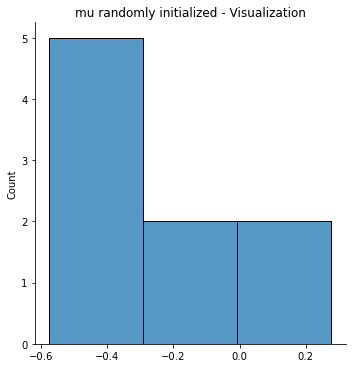

In [56]:
sns.displot(data = mu_wts.flatten(), bins = int(np.ceil(np.sqrt(mu_wts.size))))
plt.title("mu randomly initialized - Visualization")
plt.show()

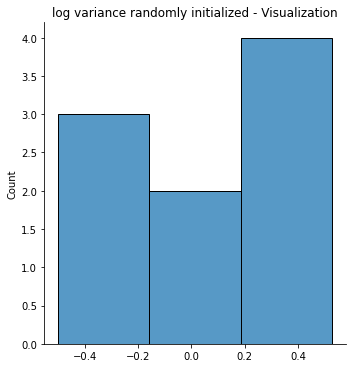

In [57]:
sns.displot(data = log_var_wts.flatten(), bins = int(np.ceil(np.sqrt(log_var_wts.size))))
plt.title("log variance randomly initialized - Visualization")
plt.show()

In [58]:
del mu_wts, log_var_wts

In [68]:
images = images.to(device)

In [69]:
images.shape

torch.Size([32, 1, 28, 28])

In [70]:
images.min(), images.max()

(tensor(0., device='cuda:0'), tensor(255., device='cuda:0'))

In [71]:
# Sanity check-
recon_images, mu, log_var = model(images)

In [72]:
recon_images.shape, mu.shape, log_var.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32, 3]), torch.Size([32, 3]))

In [73]:
recon_images.min().detach().cpu().numpy(), recon_images.max().detach().cpu().numpy()

(array(0.32189932, dtype=float32), array(0.6281065, dtype=float32))

In [65]:
del recon_images, mu, log_var

In [66]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.001 will be used


In [67]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [109]:
def total_loss(data, data_recon, mu, log_var, alpha = 1):
    '''
    Function to compute loss = reconstruction loss * reconstruction_term_weight + KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. mu: mean from the latent vector
    2. logvar: log variance from the latent vector
    3. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss - reconstruction term weight
    4. data: training data
    5. data_recon: VAE's reconstructed data
    '''
    
    # Sum over latent dimensions-
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var), axis = 1)
    # kl_div = -0.5 * torch.sum(1 + log_var - (mu **2) - torch.exp(log_var), axis = 1)
    
    # kl_div.shape
    # torch.Size([32])
    
    batchsize = kl_div.size(0)

    # Average over batch dimension-
    kl_div = kl_div.mean()
    
    reconstruction_loss_fn = F.mse_loss
    recon_loss = reconstruction_loss_fn(data_recon, data, reduction = 'none')
    
    # recon_loss.shape
    # torch.Size([32, 1, 28, 28])
    
    # Sum over all pixels-
    recon_loss = recon_loss.view(batchsize, -1).sum(axis = 1)
    
    # recon_loss.shape
    # torch.Size([32])
    
    # Average over mini-batch dimension-
    recon_loss = recon_loss.mean()
    
    final_loss = (alpha * recon_loss) + kl_div
    
    return final_loss, recon_loss, kl_div


In [ ]:
'''
# Sanity check-
final_loss, recon_loss, kl_div_loss = total_loss(
    data = images, data_recon = recon_images,
    mu = mu, log_var = log_var,
    alpha = 1
)
'''

In [ ]:
'''
print(f"final loss = {final_loss.cpu().detach().numpy():.4f},"
      f" reconstruction loss = {recon_loss.cpu().detach().numpy():.4f}"
      f" & kl-div loss = {kl_div_loss.cpu().detach().numpy():.4f}"
     )
'''

In [126]:
def train_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    # Initialize variables to keep track of 3 losses-
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    
    for i, data in tqdm(
        enumerate(dataloader),
        # total = int(len(train_dataset) / dataloader.batch_size)
        total = int(len(train) / dataloader.batch_size)
        ):
      
        # Ignore labels-
        # data, _ = data

        # Push data points to 'device'-
        data = data.to(device)
        
        # Flatten input data to feed into a dense layer-
        # data = data.view(data.size(0), -1)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        recon_data, mu, logvar = model(data)
        
        final_loss, recon_loss, kl_div_loss = total_loss(
            data = data, data_recon = recon_data,
            mu = mu, log_var = logvar,
            alpha = alpha
        )
        
        # Update losses-
        running_final_loss += final_loss.item()
        running_kl_loss += kl_div_loss.cpu().detach().numpy()
        running_recon_loss += recon_loss.cpu().detach().numpy()
        
        # Compute gradients wrt total loss-
        final_loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
    
    # Compute losses as float values-
    train_loss = running_final_loss / len(dataloader.dataset)
    kl_loss = running_kl_loss / len(dataloader.dataset)
    recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return train_loss, kl_loss, recon_loss


In [127]:
def validate_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            # total = int(len(test_dataset) / dataloader.batch_size)):
            total = int(len(test) / test_loader.batch_size)):
          
            # Ignore labels-
            # data, _ = data

            # Push data points to 'device'-
            data = data.to(device)
            
            # Flatten data to feed into a dense layer-
            # data = data.view(data.size(0), -1)
            
            # Forward propagation-
            recon_data, mu, logvar = model(data)
            
            final_loss, recon_loss, kl_div_loss = total_loss(
                data = data, data_recon = recon_data,
                mu = mu, log_var = logvar,
                alpha = alpha
            )
        
            # Update losses-
            running_final_loss += final_loss.item()
            running_kl_loss += kl_div_loss.cpu().detach().numpy()
            running_recon_loss += recon_loss.cpu().detach().numpy()
            
                
    val_loss = running_final_loss / len(dataloader.dataset)
    val_kl_loss = running_kl_loss / len(dataloader.dataset)
    val_recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return val_loss, val_kl_loss, val_recon_loss

    

In [ ]:
'''
# Sanity check-
train_loss, kl_train_loss, recon_train_loss = train_one_epoch(
    model = model, dataloader = train_loader,
    alpha = 1
)
'''

In [ ]:
'''
val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
    model = model, dataloader = test_loader,
    alpha = 1
)
'''

In [ ]:
'''
print(f"After one epoch: train loss = {train_loss:.4f}, recon loss = {recon_train_loss:.4f}"
      f" & kl-div loss = {kl_train_loss:.4f}"
     )
'''

In [ ]:
'''
print(f"After one epoch: val train loss = {val_loss:.4f}, val recon loss = {val_recon_loss:.4f}"
      f" & val kl-div loss = {val_kl_loss:.4f}"
     )
'''

### Train VAE model 

In [132]:
# Specify alpha - Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
alpha = 1

In [133]:
# Python dict to contain training metrics-
train_history = {}

In [134]:
print(f"Training VAE model for {num_epochs} epochs")

Training VAE model for 50 epochs


In [ ]:
# Initialize parameters for Early Stopping manual implementation-
# best_val_loss = 10000
# loc_patience = 0

In [ ]:
# User input parameters for Early Stopping in manual implementation-
# minimum_delta = 0.001
# patience = 3

In [141]:
for epoch in range(1, num_epochs + 1):
    '''
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    '''
    
    # Train model for 1 epoch-
    train_loss, kl_train_loss, recon_train_loss = train_one_epoch(
        model = model, dataloader = train_loader,
        alpha = alpha
    )
    
    # Get validation after 1 epoch-
    val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
        model = model, dataloader = test_loader,
        alpha = alpha
    )
    
    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss,
        'train_recon_loss': kl_train_loss,
        'train_kl_loss': kl_train_loss,
        'val_loss': val_loss,
        'val_recon_loss': val_recon_loss,
        'val_kl_loss': val_kl_loss
    }
    
    print(f"Epoch = {epoch}; train loss = {train_loss:.4f}",
          f", kl-loss = {kl_train_loss:.4f}, recon loss = {recon_train_loss:.4f}",
          f", val loss = {val_loss:.4f}, val kl-loss = {val_kl_loss:.4f}",
          f" & val recon loss = {val_recon_loss:.4f}"
         )
    
    '''
    # Code for manual Early Stopping:
    if (val_epoch_loss < best_val_loss) and \
    (np.abs(val_epoch_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VAE_LeNet5_MNIST_best_model.pth")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    '''
    
    

100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 191.22it/s]
313it [00:00, 660.19it/s]                                                                                              


Epoch = 1; train loss = 1.4284 , kl-loss = 0.0684, recon loss = 1.3601 , val loss = 1.4130, val kl-loss = 0.0728  & val recon loss = 1.3402


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 192.74it/s]
313it [00:00, 642.57it/s]                                                                                              


Epoch = 2; train loss = 1.3919 , kl-loss = 0.0820, recon loss = 1.3099 , val loss = 1.3554, val kl-loss = 0.0994  & val recon loss = 1.2559


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 192.44it/s]
313it [00:00, 667.23it/s]                                                                                              


Epoch = 3; train loss = 1.3339 , kl-loss = 0.1068, recon loss = 1.2271 , val loss = 1.3048, val kl-loss = 0.1146  & val recon loss = 1.1902


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 192.30it/s]
313it [00:00, 667.23it/s]                                                                                              


Epoch = 4; train loss = 1.2761 , kl-loss = 0.1229, recon loss = 1.1532 , val loss = 1.2548, val kl-loss = 0.1305  & val recon loss = 1.1242


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 190.14it/s]
313it [00:00, 612.39it/s]                                                                                              


Epoch = 5; train loss = 1.2404 , kl-loss = 0.1315, recon loss = 1.1088 , val loss = 1.2337, val kl-loss = 0.1366  & val recon loss = 1.0971


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 190.41it/s]
313it [00:00, 657.41it/s]                                                                                              


Epoch = 6; train loss = 1.2185 , kl-loss = 0.1369, recon loss = 1.0816 , val loss = 1.2032, val kl-loss = 0.1408  & val recon loss = 1.0624


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 190.99it/s]
313it [00:00, 653.30it/s]                                                                                              


Epoch = 7; train loss = 1.2061 , kl-loss = 0.1407, recon loss = 1.0654 , val loss = 1.1931, val kl-loss = 0.1412  & val recon loss = 1.0519


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 183.67it/s]
313it [00:00, 605.28it/s]                                                                                              


Epoch = 8; train loss = 1.1936 , kl-loss = 0.1447, recon loss = 1.0489 , val loss = 1.1860, val kl-loss = 0.1473  & val recon loss = 1.0387


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 192.38it/s]
313it [00:00, 670.08it/s]                                                                                              


Epoch = 9; train loss = 1.1849 , kl-loss = 0.1467, recon loss = 1.0382 , val loss = 1.1839, val kl-loss = 0.1505  & val recon loss = 1.0335


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 192.48it/s]
313it [00:00, 650.58it/s]                                                                                              


Epoch = 10; train loss = 1.1782 , kl-loss = 0.1485, recon loss = 1.0297 , val loss = 1.1769, val kl-loss = 0.1511  & val recon loss = 1.0258


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 192.84it/s]
313it [00:00, 653.30it/s]                                                                                              


Epoch = 11; train loss = 1.1734 , kl-loss = 0.1496, recon loss = 1.0238 , val loss = 1.1743, val kl-loss = 0.1483  & val recon loss = 1.0261


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 190.20it/s]
313it [00:00, 675.87it/s]                                                                                              


Epoch = 12; train loss = 1.1677 , kl-loss = 0.1509, recon loss = 1.0168 , val loss = 1.1610, val kl-loss = 0.1511  & val recon loss = 1.0099


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:10<00:00, 180.98it/s]
313it [00:00, 656.04it/s]                                                                                              


Epoch = 13; train loss = 1.1640 , kl-loss = 0.1526, recon loss = 1.0115 , val loss = 1.1615, val kl-loss = 0.1509  & val recon loss = 1.0106


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 191.87it/s]
313it [00:00, 670.08it/s]                                                                                              


Epoch = 14; train loss = 1.1601 , kl-loss = 0.1530, recon loss = 1.0071 , val loss = 1.1528, val kl-loss = 0.1525  & val recon loss = 1.0003


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 191.32it/s]
313it [00:00, 667.23it/s]                                                                                              


Epoch = 15; train loss = 1.1562 , kl-loss = 0.1543, recon loss = 1.0019 , val loss = 1.1540, val kl-loss = 0.1534  & val recon loss = 1.0006


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 191.46it/s]
313it [00:00, 647.89it/s]                                                                                              


Epoch = 16; train loss = 1.1552 , kl-loss = 0.1549, recon loss = 1.0003 , val loss = 1.1673, val kl-loss = 0.1552  & val recon loss = 1.0121


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 192.48it/s]
313it [00:00, 675.87it/s]                                                                                              


Epoch = 17; train loss = 1.1502 , kl-loss = 0.1554, recon loss = 0.9947 , val loss = 1.1535, val kl-loss = 0.1570  & val recon loss = 0.9965


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 192.38it/s]
313it [00:00, 667.23it/s]                                                                                              


Epoch = 18; train loss = 1.1481 , kl-loss = 0.1568, recon loss = 0.9913 , val loss = 1.1497, val kl-loss = 0.1581  & val recon loss = 0.9915


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 193.10it/s]
313it [00:00, 658.80it/s]                                                                                              


Epoch = 19; train loss = 1.1464 , kl-loss = 0.1572, recon loss = 0.9892 , val loss = 1.1461, val kl-loss = 0.1571  & val recon loss = 0.9890


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 192.98it/s]
313it [00:00, 660.19it/s]                                                                                              


Epoch = 20; train loss = 1.1455 , kl-loss = 0.1571, recon loss = 0.9884 , val loss = 1.1464, val kl-loss = 0.1569  & val recon loss = 0.9894


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 192.26it/s]
313it [00:00, 657.42it/s]                                                                                              


Epoch = 21; train loss = 1.1419 , kl-loss = 0.1584, recon loss = 0.9835 , val loss = 1.1384, val kl-loss = 0.1584  & val recon loss = 0.9800


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 192.78it/s]
313it [00:00, 681.76it/s]                                                                                              


Epoch = 22; train loss = 1.1390 , kl-loss = 0.1582, recon loss = 0.9808 , val loss = 1.1548, val kl-loss = 0.1591  & val recon loss = 0.9956


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 193.04it/s]
313it [00:00, 670.09it/s]                                                                                              


Epoch = 23; train loss = 1.1392 , kl-loss = 0.1595, recon loss = 0.9797 , val loss = 1.1337, val kl-loss = 0.1613  & val recon loss = 0.9725


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 193.16it/s]
313it [00:00, 661.58it/s]                                                                                              


Epoch = 24; train loss = 1.1364 , kl-loss = 0.1589, recon loss = 0.9775 , val loss = 1.1352, val kl-loss = 0.1597  & val recon loss = 0.9755


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 193.02it/s]
313it [00:00, 650.58it/s]                                                                                              


Epoch = 25; train loss = 1.1345 , kl-loss = 0.1601, recon loss = 0.9745 , val loss = 1.1525, val kl-loss = 0.1584  & val recon loss = 0.9942


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 194.64it/s]
313it [00:00, 677.33it/s]                                                                                              


Epoch = 26; train loss = 1.1348 , kl-loss = 0.1603, recon loss = 0.9744 , val loss = 1.1420, val kl-loss = 0.1589  & val recon loss = 0.9831


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.09it/s]
313it [00:00, 672.96it/s]                                                                                              


Epoch = 27; train loss = 1.1348 , kl-loss = 0.1603, recon loss = 0.9745 , val loss = 1.1399, val kl-loss = 0.1609  & val recon loss = 0.9790


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 194.72it/s]
313it [00:00, 667.23it/s]                                                                                              


Epoch = 28; train loss = 1.1314 , kl-loss = 0.1606, recon loss = 0.9708 , val loss = 1.1351, val kl-loss = 0.1602  & val recon loss = 0.9750


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.31it/s]
313it [00:00, 681.76it/s]                                                                                              


Epoch = 29; train loss = 1.1304 , kl-loss = 0.1610, recon loss = 0.9694 , val loss = 1.1327, val kl-loss = 0.1603  & val recon loss = 0.9724


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.29it/s]
313it [00:00, 658.80it/s]                                                                                              


Epoch = 30; train loss = 1.1299 , kl-loss = 0.1612, recon loss = 0.9687 , val loss = 1.1389, val kl-loss = 0.1610  & val recon loss = 0.9779


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.00it/s]
313it [00:00, 660.19it/s]                                                                                              


Epoch = 31; train loss = 1.1280 , kl-loss = 0.1618, recon loss = 0.9662 , val loss = 1.1258, val kl-loss = 0.1609  & val recon loss = 0.9650


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.13it/s]
313it [00:00, 662.98it/s]                                                                                              


Epoch = 32; train loss = 1.1248 , kl-loss = 0.1619, recon loss = 0.9629 , val loss = 1.1316, val kl-loss = 0.1611  & val recon loss = 0.9705


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.59it/s]
313it [00:00, 675.87it/s]                                                                                              


Epoch = 33; train loss = 1.1241 , kl-loss = 0.1624, recon loss = 0.9617 , val loss = 1.1318, val kl-loss = 0.1655  & val recon loss = 0.9663


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 194.24it/s]
313it [00:00, 668.65it/s]                                                                                              


Epoch = 34; train loss = 1.1228 , kl-loss = 0.1627, recon loss = 0.9601 , val loss = 1.1292, val kl-loss = 0.1636  & val recon loss = 0.9656


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.00it/s]
313it [00:00, 665.81it/s]                                                                                              


Epoch = 35; train loss = 1.1236 , kl-loss = 0.1626, recon loss = 0.9610 , val loss = 1.1296, val kl-loss = 0.1619  & val recon loss = 0.9676


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.11it/s]
313it [00:00, 672.97it/s]                                                                                              


Epoch = 36; train loss = 1.1222 , kl-loss = 0.1638, recon loss = 0.9584 , val loss = 1.1277, val kl-loss = 0.1639  & val recon loss = 0.9638


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.21it/s]
313it [00:00, 662.99it/s]                                                                                              


Epoch = 37; train loss = 1.1221 , kl-loss = 0.1626, recon loss = 0.9595 , val loss = 1.1311, val kl-loss = 0.1656  & val recon loss = 0.9655


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 192.24it/s]
313it [00:00, 665.80it/s]                                                                                              


Epoch = 38; train loss = 1.1204 , kl-loss = 0.1633, recon loss = 0.9571 , val loss = 1.1207, val kl-loss = 0.1621  & val recon loss = 0.9586


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 194.34it/s]
313it [00:00, 671.52it/s]                                                                                              


Epoch = 39; train loss = 1.1199 , kl-loss = 0.1632, recon loss = 0.9567 , val loss = 1.1194, val kl-loss = 0.1615  & val recon loss = 0.9579


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 194.46it/s]
313it [00:00, 681.76it/s]                                                                                              


Epoch = 40; train loss = 1.1193 , kl-loss = 0.1632, recon loss = 0.9561 , val loss = 1.1235, val kl-loss = 0.1625  & val recon loss = 0.9610


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.25it/s]
313it [00:00, 665.81it/s]                                                                                              


Epoch = 41; train loss = 1.1185 , kl-loss = 0.1639, recon loss = 0.9546 , val loss = 1.1229, val kl-loss = 0.1615  & val recon loss = 0.9614


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.00it/s]
313it [00:00, 668.65it/s]                                                                                              


Epoch = 42; train loss = 1.1160 , kl-loss = 0.1638, recon loss = 0.9522 , val loss = 1.1181, val kl-loss = 0.1637  & val recon loss = 0.9544


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.09it/s]
313it [00:00, 668.65it/s]                                                                                              


Epoch = 43; train loss = 1.1166 , kl-loss = 0.1639, recon loss = 0.9527 , val loss = 1.1150, val kl-loss = 0.1662  & val recon loss = 0.9488


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.21it/s]
313it [00:00, 675.87it/s]                                                                                              


Epoch = 44; train loss = 1.1158 , kl-loss = 0.1641, recon loss = 0.9518 , val loss = 1.1183, val kl-loss = 0.1632  & val recon loss = 0.9550


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.02it/s]
313it [00:00, 670.08it/s]                                                                                              


Epoch = 45; train loss = 1.1163 , kl-loss = 0.1641, recon loss = 0.9522 , val loss = 1.1276, val kl-loss = 0.1638  & val recon loss = 0.9638


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 194.90it/s]
313it [00:00, 657.41it/s]                                                                                              


Epoch = 46; train loss = 1.1136 , kl-loss = 0.1643, recon loss = 0.9493 , val loss = 1.1156, val kl-loss = 0.1634  & val recon loss = 0.9523


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.07it/s]
313it [00:00, 662.98it/s]                                                                                              


Epoch = 47; train loss = 1.1123 , kl-loss = 0.1645, recon loss = 0.9478 , val loss = 1.1127, val kl-loss = 0.1649  & val recon loss = 0.9477


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 194.28it/s]
313it [00:00, 672.96it/s]                                                                                              


Epoch = 48; train loss = 1.1121 , kl-loss = 0.1648, recon loss = 0.9473 , val loss = 1.1179, val kl-loss = 0.1651  & val recon loss = 0.9529


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.17it/s]
313it [00:00, 670.08it/s]                                                                                              


Epoch = 49; train loss = 1.1127 , kl-loss = 0.1648, recon loss = 0.9478 , val loss = 1.1099, val kl-loss = 0.1634  & val recon loss = 0.9465


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 195.11it/s]
313it [00:00, 653.29it/s]                                                                                              

Epoch = 50; train loss = 1.1095 , kl-loss = 0.1650, recon loss = 0.9445 , val loss = 1.1121, val kl-loss = 0.1661  & val recon loss = 0.9459


In [142]:
train_history.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [143]:
train_history[2].keys()

dict_keys(['train_loss', 'train_recon_loss', 'train_kl_loss', 'val_loss', 'val_recon_loss', 'val_kl_loss'])

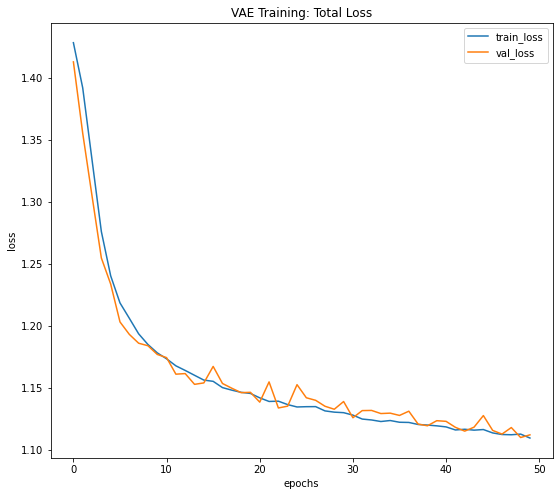

In [146]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'train_loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Total Loss")
plt.show()

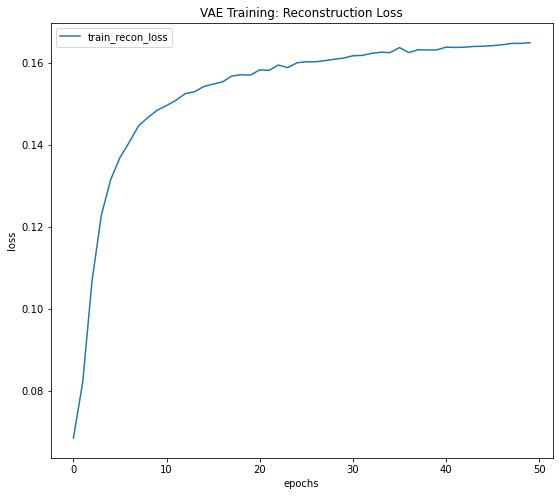

In [148]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_recon_loss'] for e in train_history.keys()], label = 'train_recon_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Reconstruction Loss")
plt.show()

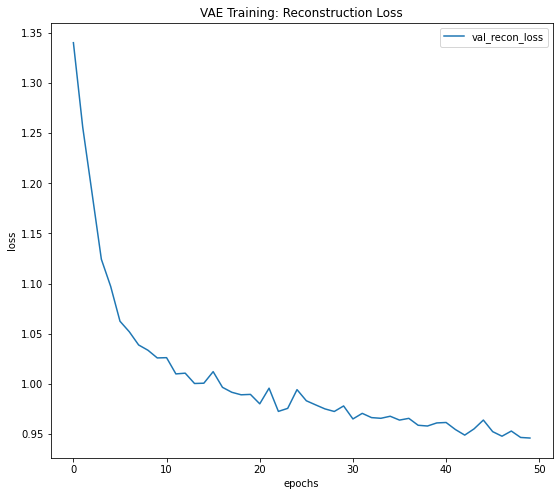

In [149]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['val_recon_loss'] for e in train_history.keys()], label = 'val_recon_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Reconstruction Loss")
plt.show()

_Reconstruction loss_ has 2 plots since training and validation losses are on different scales.

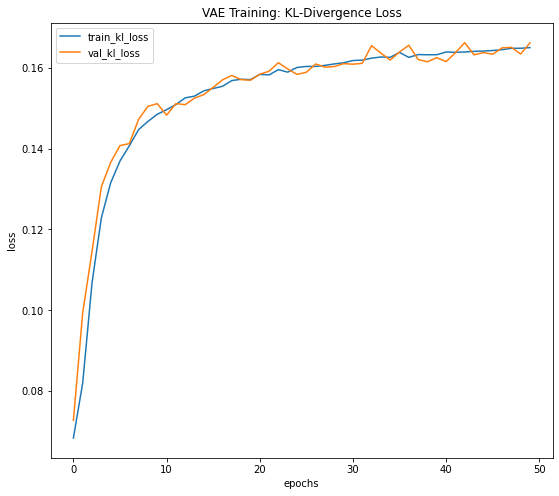

In [150]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_kl_loss'] for e in train_history.keys()], label = 'train_kl_loss')
plt.plot([train_history[e]['val_kl_loss'] for e in train_history.keys()], label = 'val_kl_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: KL-Divergence Loss")
plt.show()

In [151]:
# Save trained VAE model's weights-
torch.save(model.state_dict(), 'VAE_LeNet5_MNIST_Trained_Weights.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_Dense(latent_space = 3).to(device)
# loaded_model.load_state_dict(torch.load('VAE_LeNet5_MNIST_Trained_Weights.pth', map_location = torch.device('cpu')))

In [ ]:
# Define gradient descent optimizer-
# optimizer = torch.optim.Adam(loaded_model.parameters(), lr = learning_rate)

In [152]:
import pickle

# Save training history as pickle file-
with open("VAE_LeNet5_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_LeNet5_MNIST_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

### Reconstruct/Generate images using _trained_ VAE model

In [155]:
images = next(iter(train_loader))

In [156]:
images = images.to(device)

In [157]:
images_recon, mu, log_var = model(images)

In [158]:
images.shape, images_recon.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32, 1, 28, 28]))

In [159]:
mu.shape, log_var.shape

(torch.Size([32, 3]), torch.Size([32, 3]))

In [160]:
images_recon = images_recon.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()
log_var = log_var.cpu().detach().numpy()

In [162]:
images = images.cpu().detach().numpy()

In [167]:
images.shape, images_recon.shape

((32, 1, 28, 28), (32, 1, 28, 28))

In [171]:
np.transpose(images, (0, 2, 3, 1)).shape

(32, 28, 28, 1)

In [172]:
np.transpose(images_recon, (0, 2, 3, 1)).shape

(32, 28, 28, 1)

In [179]:
images = np.transpose(images, (0, 2, 3, 1))

In [180]:
images_recon = np.transpose(images_recon, (0, 2, 3, 1))

In [181]:
images.shape, images_recon.shape

((32, 28, 28, 1), (32, 28, 28, 1))

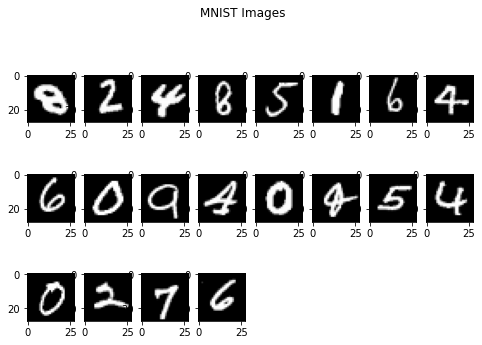

In [186]:
# Visualize 32 images from training set-
plt.figure(figsize = (8, 7))
for i in range(20):
    # 4 rows and 8 columns-
    plt.subplot(4, 8, i + 1)
    plt.imshow(images[i], cmap = 'gray')

plt.suptitle("MNIST Images")
plt.show()

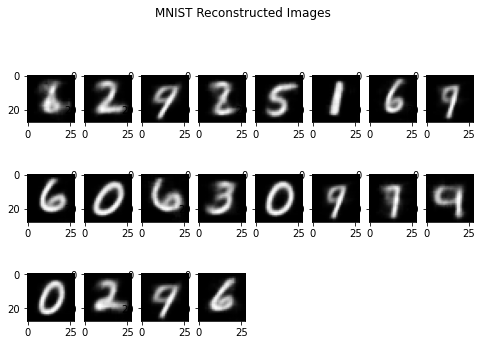

In [187]:
# Visualize 32 reconstructed images-
plt.figure(figsize = (8, 7))
for i in range(20):
    # 4 rows and 8 columns-
    plt.subplot(4, 8, i + 1)
    plt.imshow(images_recon[i], cmap = 'gray')

plt.suptitle("MNIST Reconstructed Images")
plt.show()

In [192]:
train.shape

torch.Size([60000, 1, 28, 28])

In [230]:
train = train.to(device)

In [ ]:
_, mu, log_var = model(train)

In [232]:
mu.shape, log_var.shape

((60000, 3), (60000, 3))

In [225]:
train.shape

torch.Size([60000, 1, 28, 28])

In [226]:
mu = mu.cpu().detach().numpy()
log_var = log_var.cpu().detach().numpy()

In [227]:
train = train.cpu().detach()

In [228]:
# Sanity check-
mu.shape, log_var.shape

((60000, 3), (60000, 3))

In [229]:
train.shape

torch.Size([60000, 1, 28, 28])

### Visualize _mu_ & _log_var_ trained vectors

In [215]:
import plotly
import plotly.express as px

In [ ]:
# Visualize latent space for 'mu' vector-
fig = px.scatter_3d(
    x = mu[:, 0], y = mu[:, 1],
    z = mu[:, 2],
    # color = y_train
    )
fig.show()

In [ ]:
# Visualize latent space for 'log variance' vector-
fig = px.scatter_3d(
    x = log_var[:, 0], y = log_var[:, 1],
    z = log_var[:, 2],
    # color = y_train
    )
fig.show()

In [217]:
print(f"Mean vector (mu): mean = {mu.mean():4f} & std dev = {mu.std():.4f}")

Mean vector (mu): mean = -0.008894 & std dev = 0.8598


In [218]:
print(f"log-variance (log-var): mean = {log_var.mean():.4f} & std dev = {log_var.std():.4f}")

log-variance (log-var): mean = -3.4641 & std dev = 2.5549


In [204]:
np.sum(mu, axis = 0)

array([-1483.6248  ,    20.069199,  -137.35129 ], dtype=float32)

In [205]:
np.sum(log_var, axis = 0)

array([-2.7039500e+05,  3.3001474e+02, -3.5346928e+05], dtype=float32)

In [ ]:
for i in range(3):
    print(f"lv = {i + 1}: mean = {train_recon[:, i].mean():.4f} & std dev ="
          f" {train_recon[:, i].std():.4f}"
         )